In [ ]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataroot = 'data/airfoil_interp.npy'
data = np.load(dataroot)

In [ ]:
fig, axs = plt.subplots(1, 1)
axs.plot(data[0,:,0], data[0,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()


In [ ]:
sample = np.load('sample.npy')
# sample = np.squeeze(sample, axis=1)

In [ ]:
i = 1
fig, axs = plt.subplots(1, 1)
axs.plot(sample[i,:,0], sample[i,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [ ]:
xhat, yhat = savgol_filter((sample[i,:,0], sample[i,:,1]), 10, 3)
fig, axs = plt.subplots(1, 1)
axs.plot(xhat, yhat)
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [ ]:
abs(yhat[:128] - np.flip(yhat[-128:])).max()

In [ ]:
import numpy as np
from xfoil import XFoil
from xfoil.model import Airfoil
import matplotlib.pyplot as plt

best_perf = 0
for i in range(64):
    airfoil = sample[i,:,:]
    xf = XFoil()
    xf.airfoil = Airfoil(airfoil[:,0], airfoil[:,1])
    xf.Re = 4.5e4
    xf.max_iter = 200
    a, cl, cd, cm, cp = xf.cseq(0.6, 0.8, 0.05)
    perf = (cl/cd).max()
    if perf == np.nan:
        pass
    elif perf > best_perf:
        best_perf = perf

In [ ]:
best_perf

In [ ]:
from simulation import evaluate
cl = 0.65
best_perf = 0
for i in range(data.shape[0]):
    airfoil = data[i,:,:]
    perf = evaluate(airfoil, cl)
    if perf == np.nan:
        pass
    elif perf > best_perf:
        best_perf = perf

In [ ]:
best_perf

In [8]:
airfoil1D = np.loadtxt('results/airfoil1D.dat')
airfoil = np.loadtxt('results/airfoil.dat')

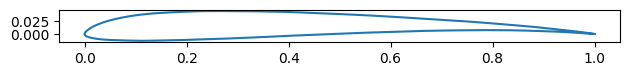

In [9]:
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil1D[:,0], airfoil1D[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

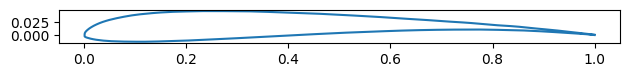

In [10]:
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil[:,0], airfoil[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [62]:
def derotate(airfoil):
    ptail = 0.5 * (airfoil[0,:]+airfoil[-1,:])
    ptails = np.expand_dims(ptail, axis=0)
    ptails = np.repeat(ptails, 256, axis=0)
    i = np.linalg.norm(airfoil - ptails, axis=1).argmax()
    phead = airfoil[i,:]
    theta = np.arctan2(-(airfoil[i,1] - ptail[1]), -(airfoil[i,0] - ptail[0]))
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    airfoil_R = airfoil
    airfoil_R -= np.repeat(np.expand_dims(phead, axis=0), 256, axis=0)
    airfoil_R = np.matmul(airfoil_R, R)
    return airfoil_R

def Normalize(airfoil):
    r = np.maximum(airfoil[0,0], airfoil[-1,0])
    r = float(1.0/r)
    return airfoil * r

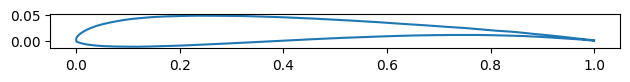

In [63]:
airfoil_R = derotate(airfoil)
airfoil_R = Normalize(airfoil_R)
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil_R[:,0], airfoil_R[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [64]:
ptail = 0.5 * (airfoil_R[0,:]+airfoil_R[-1,:])
ptails = np.expand_dims(ptail, axis=0)
ptails = np.repeat(ptails, 256, axis=0)
i = np.linalg.norm(airfoil_R - ptails, axis=1).argmax()
phead = airfoil_R[i,:]
theta = np.arctan2(-(airfoil_R[i,1] - ptail[1]), -(airfoil_R[i,0] - ptail[0]))
phead

array([0., 0.])

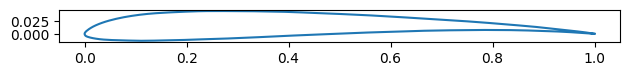

In [66]:
airfoil_R1D = derotate(airfoil1D)
airfoil_R1D = Normalize(airfoil_R1D)
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil_R1D[:,0], airfoil_R1D[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()